In [176]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import tempfile

plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex = True)

def run_MC(dims=1, n=1, n_mc=100, alpha=0.5, beta=1,
           omega_ho=1, omega_z=1, a=0, h=0.001,
           dt=0.1, step_length=1, importance=True,
           analytic=True, elliptic=False):
    options = ('{} '*14).format(int(analytic),
                                int(importance),
                                int(elliptic),
                                dims,
                                n,
                                n_mc,
                                alpha,
                                beta,
                                dt,
                                step_length,
                                omega_ho,
                                omega_z,
                                a,
                                h)
    filename = tempfile.mktemp(prefix='run-', suffix='_'.join(options.split(' ')))
    
    with os.popen('../build-src-Desktop-Release/run_mc.x {} {}'.format(options, filename)) as cmd:
        output = [float(i) for i in cmd.read().strip().split(',')]
        
    E = np.fromfile(filename, count=n_mc*n, dtype=np.float64)
    return E, output

def E_and_var(**kwargs):
    energies, _ = run_MC(**kwargs)
    E_L = np.mean(energies)
    var = np.var(energies)
    return E_L, var

def E_and_var_plot_for_alphas(alphas, dts=(0.1,), verbose=True, saveas=None, **kwargs):
    E   = np.empty((len(dts), len(alphas)))
    var = np.empty((len(dts), len(alphas)))
    
    for i, dt in enumerate(dts):
        kwargs['dt'] = dt
        for j, alpha in enumerate(alphas):
            kwargs['alpha'] = alpha
            E[i, j], var[i, j] = E_and_var(**kwargs)
    
    min_E, min_var = np.argmin(E, axis=1), np.argmin(var, axis=1)
    
    
    if verbose:
        print(min_E, min_var)
    
    # Plot
    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(12, 12))
    for i, dt in enumerate(dts):
        ax[0].plot(alphas, E[i, :], label=r'$\Delta t={}$'.format(dt))
        ax[0].plot([alphas[min_E[i]]], [E[i, min_E[i]]], 'ro')
        
        ax[1].plot(alphas, var[i, :])
        ax[1].plot([alphas[min_var[i]]], [var[i, min_var[i]]], 'ro')
        
    ax[0].set_ylabel(r'$\langle H\rangle$', fontsize=26)
    ax[0].set_title(r'Ground state energy as function of variational parameter $\alpha$', fontsize=22)

    ax[1].set_xlabel(r'$\alpha$', fontsize=26)
    ax[1].set_ylabel(r'$\sigma^2_{E_L}$', fontsize=26)
    ax[1].set_title(r'Variance as function of variational parameter $\alpha$', fontsize=22)

    
    plt.tight_layout()
    
        
    if len(dts) > 1:
        fig.legend(loc='upper right', bbox_to_anchor=(0, 0, 0.95, 0.95), fontsize=22)
    
    if saveas:
        plt.savefig(saveas)
    
    plt.show()
    ': 6}

def make_configuration_table(filename, verbose=True, dims=(1,2,3), ns=(1, 10, 100, 500), 
                             analytics=(1, 0), dts=(0.1,), importance=False, **kwargs):
    
    kwargs['importance'] = importance
    
    output =  'Dims, Number of particles, Analytic{}, '.format(', Time step' if importance else '')
    output += 'Energy, Variance, Acceptance rate, Time spent\n' 
    
    if verbose:
        print(output, end='')
    
    fmt = '{0:d}, {1:3d}, {2:3s}, {7:s}{3:4.6e}, {4:4.6e}, {5:4.2f}, {6:7.2e}'
    
    for d in dims:
        kwargs['dims'] = d
        for n in [1, 10, 100, 500]:
            kwargs['n'] = n
            for analytic in [0, 1]:
                kwargs['analytic'] = analytic
                for dt in dts:
                    kwargs['dt'] = dt
                    
                    E, (_, _, _, _, _, ar, t) = run_MC(**kwargs)
                    
                    energy = np.mean(E)
                    var = np.var(E)
                
                    imp_fmt = '' if len(dts) == 1 else '{:3.2e}, '.format(dt)
                    line = fmt.format(d, n, 'ON' if analytic else 'OFF', energy, var, ar, t, imp_fmt)
                    
                    if verbose:
                        print(line)
                        
                    output += line + '\n'
    
    with open(filename, 'w') as f:
        f.write(output)


[12] [12]


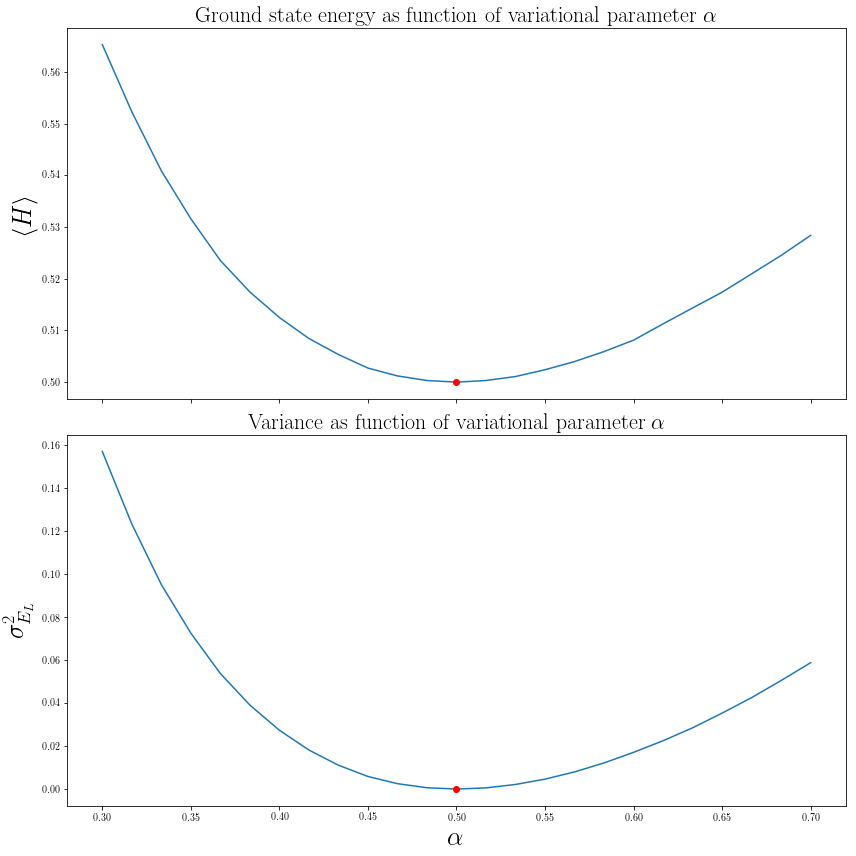

In [177]:
E_and_var_plot_for_alphas(np.linspace(0.3, 0.7, 25), 
                          n_mc=int(1e4), importance=True, dts=[0.1],
                          saveas='../results/var-alpha-plot-imp-10000.png')

[10] [12]


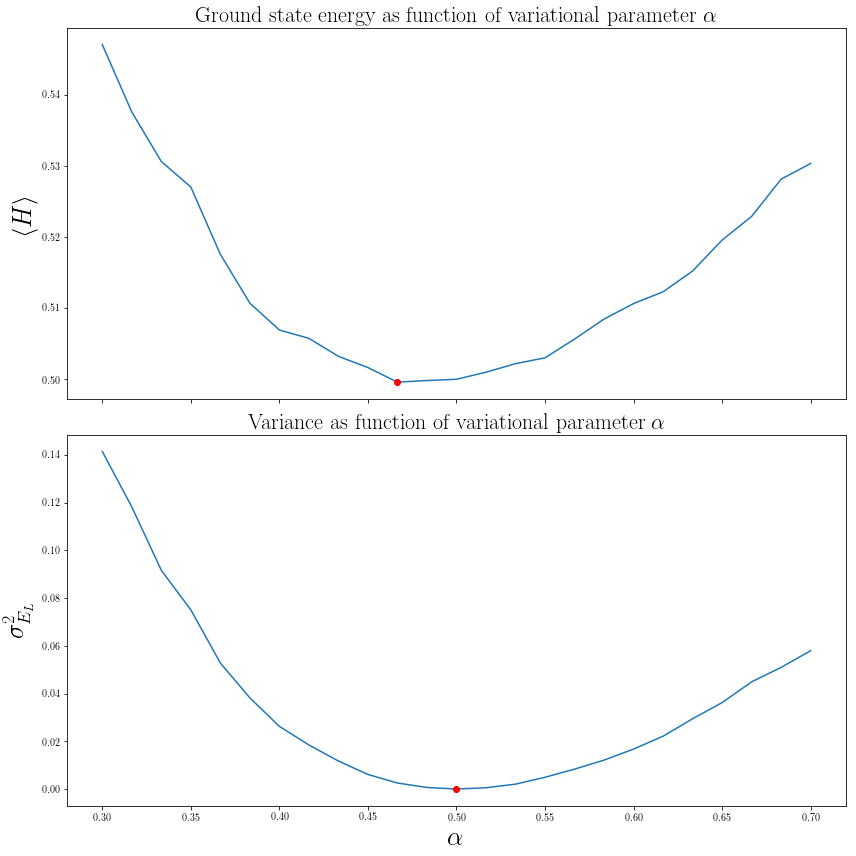

In [178]:
E_and_var_plot_for_alphas(np.linspace(0.3, 0.7, 25), 
                          n_mc=int(1e4), importance=False, 
                          saveas='../results/var-alpha-plot-noimp-10000.png')

[10 12 15 18  3] [12 12 12 12 12]


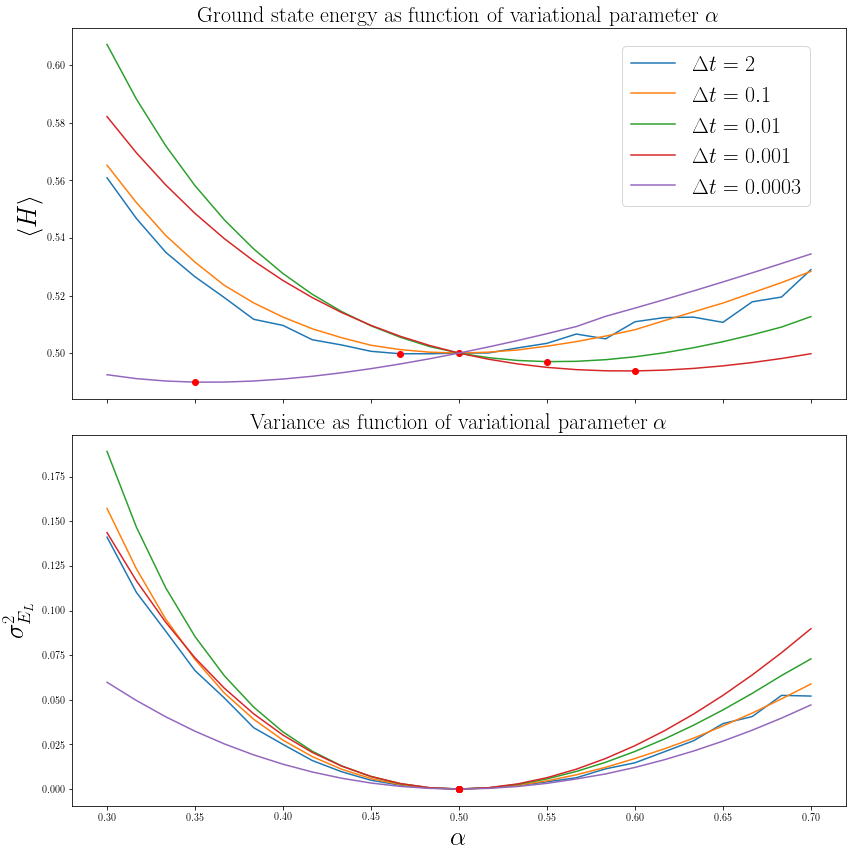

In [179]:
E_and_var_plot_for_alphas(np.linspace(0.3, 0.7, 25), 
                          n_mc=int(1e4), importance=True, dts=[2, 0.1, 0.01, 0.001, 0.0003],
                          saveas='../results/var-alpha-plot-imp-dts-10000.png')

In [76]:
# Do not run this cell if you don't need to. It takes a while...
make_configuration_table('../results/vmc_configurations.csv', n_mc=100)
make_configuration_table('../results/vmc_imp_configurations.csv', n_mc=100, importance=True, dts=(1, 0.1, 0.01))

Dims, Number of particles, Analytic, Energy, Variance, Acceptance rate, Time spent
1,   1, OFF, 4.999999e-01, 2.468504e-15, 0.82, 6.00e-05
1,   1, ON , 5.000000e-01, 0.000000e+00, 0.82, 4.80e-05
1,  10, OFF, 5.000000e+00, 1.110006e-13, 0.88, 2.34e-03
1,  10, ON , 5.000000e+00, 9.624103e-32, 0.88, 5.34e-04
1, 100, OFF, 5.000000e+01, 2.618902e-12, 0.87, 7.66e-01
1, 100, ON , 5.000000e+01, 4.143476e-29, 0.87, 3.15e-02
1, 500, OFF, 2.500000e+02, 4.534363e-11, 0.86, 8.73e+01
1, 500, ON , 2.500000e+02, 4.204242e-27, 0.86, 7.74e-01
2,   1, OFF, 9.999999e-01, 9.514142e-15, 0.81, 5.30e-05
2,   1, ON , 1.000000e+00, 0.000000e+00, 0.81, 3.50e-05
2,  10, OFF, 9.999999e+00, 2.095685e-13, 0.79, 3.19e-03
2,  10, ON , 1.000000e+01, 2.871454e-31, 0.79, 4.58e-04
2, 100, OFF, 9.999999e+01, 9.343919e-12, 0.80, 1.77e+00
2, 100, ON , 1.000000e+02, 2.646736e-28, 0.80, 3.58e-02
2, 500, OFF, 5.000000e+02, 2.731972e-10, 0.79, 2.05e+02
2, 500, ON , 5.000000e+02, 1.681820e-26, 0.79, 8.89e-01
3,   1, OFF, 1.500000